In [29]:
import pandas as pd

# Example data loading
data = pd.read_csv('grouped_data_by_date_people (1).csv')
data['y_items'] = pd.to_datetime(data['y_items'])
data.set_index('y_items', inplace=True)


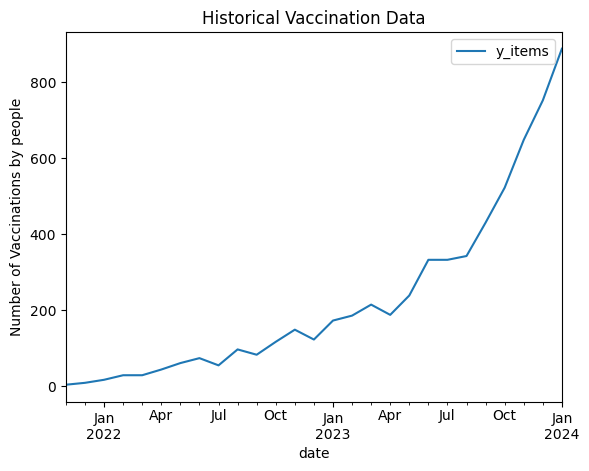

In [18]:
import matplotlib.pyplot as plt

data.plot()
plt.title('Historical Vaccination Data')
plt.ylabel('Number of Vaccinations by people')
plt.show()


ADF Statistic: 3.7389173284792037
p-value: 1.0
Series is not stationary. Differencing applied.


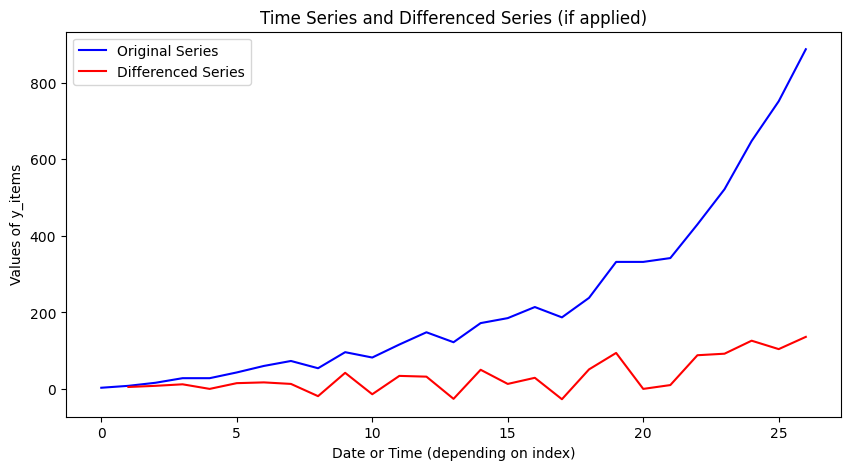

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load your data
data = pd.read_csv('grouped_data_by_date_people (1).csv')  # Update the path to your actual file

# Perform the Augmented Dickey-Fuller test
result = adfuller(data['y_items'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Plot original data
plt.figure(figsize=(10, 5))
plt.plot(data['y_items'], label='Original Series', color='blue')

# If p-value > 0.05, the series is not stationary and you may need to difference it
if result[1] > 0.05:
    data['diff_y_items'] = data['y_items'].diff().dropna()
    plt.plot(data['diff_y_items'], label='Differenced Series', color='red')
    print("Series is not stationary. Differencing applied.")
else:
    print("Series is stationary. No differencing needed.")

plt.title('Time Series and Differenced Series (if applied)')
plt.xlabel('Date or Time (depending on index)')
plt.ylabel('Values of y_items')
plt.legend()
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                  3.738917
p-value                         1.000000
#Lags Used                      3.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


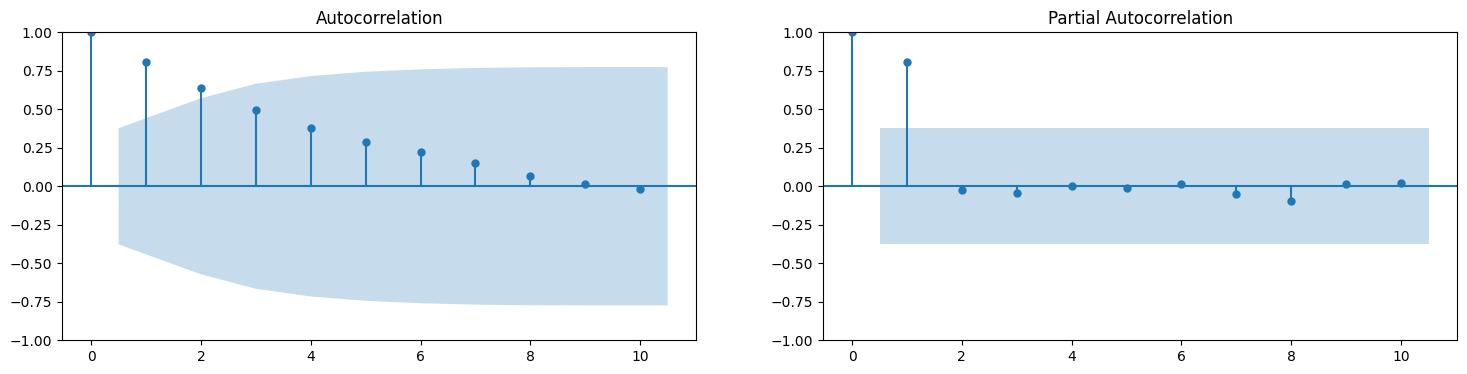

In [49]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to test stationarity
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Test stationarity
test_stationarity(data['y_items'])

# Plot ACF and PACF

# Adjust the lags to a lower number and replot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(data['y_items'], lags=10, ax=ax1)
plot_pacf(data['y_items'], lags=10, ax=ax2, method='ywm')
plt.show()


In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming you have determined the best parameters (p, d, q) and seasonal parameters (P, D, Q, m)
model = SARIMAX(data['y_items'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))
results = model.fit()

print(results.summary())


/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                            y_items   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -74.534
Date:                            Wed, 24 Apr 2024   AIC                            159.069
Time:                                    11:05:25   BIC                            162.264
Sample:                                         0   HQIC                           158.773
                                             - 27                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.030     33.560      0.000       0.941       1.058
ma.L1         -0.6381      0.596   

In [54]:
from statsmodels.tsa.arima.model import ARIMA

# Fitting the ARIMA model
model = ARIMA(data['y_items'], order=(1,1,1))
model_fit = model.fit()

# Display the summary of the model
model_fit.summary()


/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                y_items   No. Observations:                   27
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -131.646
Date:                Wed, 24 Apr 2024   AIC                            269.292
Time:                        11:05:43   BIC                            273.066
Sample:                             0   HQIC                           270.378
                                 - 27                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9748      0.075     12.930      0.000       0.827       1.123
ma.L1         -0.5864      0.218     -2.690      0.007      -1.014      -0.159
sigma2      1370.0090    542.138      2.527      0.012     307.438    2432.580
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.41   Prob(JB):                         0.65
Heteroskedasticity (H):               7.69   Skew:                            -0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# Forecast from January 2024 to December 2024
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start='2024-01-01', periods=12, freq='M')

# Adjust forecast for the marketing campaign effect from May to September 2024
adjusted_forecast = forecast.predicted_mean.copy()
adjusted_forecast['2024-05-01':'2024-09-01'] *= 1.10  # Increase by 10%

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['y_items'], label='Historical')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast')
plt.plot(forecast_index, adjusted_forecast, label='Adjusted Forecast', linestyle='--')
plt.title('Forecast and Adjusted Forecast of Vaccinations')
plt.legend()
plt.show()


<class 'TypeError'>: cannot do slice indexing on RangeIndex with these indexers [2024-05-01] of type str

In [61]:
# Initial Adjusted Forecast: Increase from May to September 2024
adjusted_forecast_plus_15000 = forecast.predicted_mean.copy()
adjusted_forecast_plus_15000['2024-05-31':'2024-09-30'] += 15000  # Adjust for end of month

# Additional Adjusted Forecast: Additional adjustment only for June 2024
adjusted_forecast_plus_27000 = adjusted_forecast_plus_15000.copy()
adjusted_forecast_plus_27000['2024-06-30'] += 27000  # Specific for end of June

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['y_items'], label='Historical', color='blue')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='green')
plt.plot(forecast_index, adjusted_forecast_plus_15000, label='Adjusted Forecast: +15,000', linestyle='--', color='orange')
plt.plot(forecast_index, adjusted_forecast_plus_27000, label='Adjusted Forecast 1: +27,000', linestyle=':', color='red')
plt.title('Forecast and Adjusted Forecasts of Vaccinations')
plt.legend()
plt.show()


<class 'TypeError'>: cannot do slice indexing on RangeIndex with these indexers [2024-05-31] of type str

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Load your SARIMA or ARIMA model's results (assumed to be in the variable 'results')
# Generate the forecast for January 2024 to December 2024
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start='2024-01-01', periods=12, freq='M')
forecast.predicted_mean.index = forecast_index  # Ensure the index is a DatetimeIndex

# Initial Adjusted Forecast: Apply a uniform increase of 15,000 from May to September 2024
adjusted_forecast_plus_15000 = forecast.predicted_mean.copy()
adjusted_forecast_plus_15000['2024-05-31':'2024-09-30'] += 15000  # Adjust for end of month

# Additional Adjusted Forecast: Apply an additional 27,000 only to June 2024
adjusted_forecast_plus_27000 = adjusted_forecast_plus_15000.copy()
adjusted_forecast_plus_27000['2024-06-30'] += 27000  # Specific for end of June

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['y_items'], label='Historical', color='blue')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='green')
plt.plot(forecast_index, adjusted_forecast_plus_15000, label='Adjusted Forecast: +15,000', linestyle='--', color='orange')
plt.plot(forecast_index, adjusted_forecast_plus_27000, label='Adjusted Forecast 1: +27,000', linestyle=':', color='red')
plt.title('Forecast and Adjusted Forecasts of Vaccinations')
plt.legend()
plt.show()


<class 'TypeError'>: cannot do slice indexing on RangeIndex with these indexers [2024-05-31] of type str

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Assuming 'results' is your forecast model's output
# Generate the forecast for January 2024 to December 2024
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start='2024-01-01', periods=12, freq='M')

# Ensure the forecast's index is set to this datetime range
forecast.predicted_mean.index = forecast_index


In [65]:
# Initial Adjusted Forecast: Apply a uniform increase of 15,000 from May to September 2024
adjusted_forecast_plus_15000 = forecast.predicted_mean.copy()
adjusted_forecast_plus_15000.loc['2024-05-31':'2024-09-30'] += 15000

# Additional Adjusted Forecast: Apply an additional 27,000 only to June 2024
adjusted_forecast_plus_27000 = adjusted_forecast_plus_15000.copy()
adjusted_forecast_plus_27000.loc['2024-06-30':'2024-09-30] += 27000


<class 'SyntaxError'>: unterminated string literal (detected at line 7) (<ipython-input-65-9f06cbd43b91>, line 7)

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Assuming 'results' is your forecast model's output
# Generate the forecast for January 2024 to December 2024
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start='2024-01-01', periods=12, freq='M')

# Ensure the forecast's index is set to this datetime range
forecast.predicted_mean.index = forecast_index

# Initial Adjusted Forecast: Apply a uniform increase of 15,000 from May to September 2024
adjusted_forecast_plus_15000 = forecast.predicted_mean.copy()
adjusted_forecast_plus_15000.loc['2024-05-31':'2024-09-30'] += 15000

# Additional Adjusted Forecast: Apply an additional 27,000 from June to September 2024
adjusted_forecast_plus_27000 = adjusted_forecast_plus_15000.copy()
adjusted_forecast_plus_27000.loc['2024-06-30':'2024-09-30'] += 27000

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['y_items'], label='Historical', color='blue')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='green')
plt.plot(forecast_index, adjusted_forecast_plus_15000, label='Adjusted Forecast


<class 'SyntaxError'>: unterminated string literal (detected at line 25) (<ipython-input-66-25cb05299706>, line 25)